In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import mixed_precision
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
2.14.0-dev20230706
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [2]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


We will be using RNN to train textual information

**Basic Structure of RNN**
* Input layer
* text_vectorizer(input)
* embedding(x)
* LSTM -> activation = tanh
* output_Dense -> activation = sigmoid

### Get the text dataset

In [3]:
if not os.path.exists("nlp_getting_started.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
    unzip_data("nlp_getting_started.zip")
else:
  print("[INFO] already exists, skipping download.")

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-08-22 17:22:54--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:822::2010, 2404:6800:4007:812::2010, 2404:6800:4007:824::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:822::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.09s   

2023-08-22 17:22:54 (6.58 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
#Shuffle to train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [7]:
# test_data
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [8]:
#How many examples in each class
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# visualise some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
print(random_index)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  index,text,target = row
  print(f"Target: {target}, {'(real disaster)' if target > 0 else '(not a real disaster)'}")
  print(f"Text:\n{text}\n")
  print("---")

7588
Target: 0, (not a real disaster)
Text:
@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO

---
Target: 1, (real disaster)
Text:
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/aueZxZA5ak

---
Target: 1, (real disaster)
Text:
24 killed in two simultaneous rail crash as acute floods derail the two trains #India #mumbai... http://t.co/b0ZwI0qPTU

---
Target: 0, (not a real disaster)
Text:
The 1st time someone blew up my phone 30 times they would be blocked. Believe it.  #Catfish

---
Target: 0, (not a real disaster)
Text:
How many cars do those cyclists wreck going past scratching with pedals. They should be banned #c4news

---


In [10]:
len(train_df_shuffled)

7613

In [11]:
#Splitting the data to create validation -> (train + validation)
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
#Check length
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check few sample
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

1. tokenization -> can get too big as the number of text sample increases
2. Embedding -> richer representation of relationship be between tokens, deeper the realtion between words, more the number/embedding for that token

In [14]:
import tensorflow as tf

# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                                    standardize="lower_and_strip_punctuation", # how to process text
                                                    split="whitespace", # how to split tokens
                                                    ngrams=None, # create groups of n-words?
                                                    output_mode="int", # how to map tokens to numbers
                                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [15]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode="int",
                                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Udhampur terror attack: Militants attack police post 2 SPOs injured http://t.co/zMWeCBWVaO      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1163, 1057,  113, 1072,  113,   77,  371,   70, 1471,  243,    1,
           0,    0,    0,    0]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [21]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Patience Jonathan On The Move To Hijack APC In BayelsaåÊState http://t.co/Vh8QtbyPZt

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[-0.02228 , -0.001288, -0.01498 , ...,  0.04364 , -0.002283,
          0.02982 ],
        [ 0.001688, -0.02943 , -0.0323  , ...,  0.04996 , -0.02803 ,
          0.003157],
        [ 0.03119 ,  0.0478  ,  0.04883 , ..., -0.03552 ,  0.03455 ,
          0.01965 ],
        ...,
        [-0.0388  , -0.03677 ,  0.02898 , ...,  0.04208 ,  0.02669 ,
          0.04123 ],
        [-0.0388  , -0.03677 ,  0.02898 , ...,  0.04208 ,  0.02669 ,
          0.04123 ],
        [-0.0388  , -0.03677 ,  0.02898 , ...,  0.04208 ,  0.02669 ,
          0.04123 ]]], dtype=float16)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float16, numpy=
array([-0.02228  , -0.001288 , -0.01498  , -0.01004  , -0.04315  ,
        0.001606 ,  0.01811  ,  0.03668  , -0.00628  ,  0.005108 ,
       -0.0452   , -0.03763  , -0.002018 ,  0.0411   ,  0.01416  ,
       -0.0422   , -0.04947  , -0.04907  ,  0.003952 , -0.0171   ,
        0.04785  , -0.04987  , -0.03616  ,  0.04794  , -0.002895 ,
       -0.01133  ,  0.03943  ,  0.007133 ,  0.04053  ,  0.02733  ,
        0.01666  , -0.02744  ,  0.04395  , -0.03406  ,  0.00288  ,
       -0.0274   ,  0.03998  ,  0.0383   ,  0.03113  , -0.0263   ,
       -0.00453  , -0.02095  ,  0.01765  ,  0.02654  , -0.00376  ,
        0.02136  ,  0.03012  , -0.001172 , -0.03384  ,  0.02698  ,
        0.04007  ,  0.03867  ,  0.01044  , -0.01015  ,  0.045    ,
        0.02043  ,  0.03958  ,  0.04782  , -0.02426  , -0.04532  ,
        0.04132  ,  0.03017  , -0.04996  ,  0.01656  ,  0.04822  ,
        0.03964  ,  0.03183  , -0.04456  , -0.01915  ,  0.0365   ,
       -0.0141

### Modelling a text dataset
More specifically, we'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data



In [24]:
#model 0
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 1: A simple dense model

In [31]:
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

# Build model with the Functional API
inputs = tf.keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [32]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230822-172420
Epoch 1/5


215/215 [==============================] - 5s 19ms/step - loss: 0.5168 - accuracy: 0.8194 - val_loss: 0.5000 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3100 - accuracy: 0.9159 - val_loss: 0.4600 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2298 - accuracy: 0.9317 - val_loss: 0.4705 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.1871 - accuracy: 0.9445 - val_loss: 0.4911 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.1587 - accuracy: 0.9511 - val_loss: 0.5157 - val_accuracy: 0.7822


In [33]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 1ms/step - loss: 0.5157 - accuracy: 0.7822


[0.5157384276390076, 0.7821522355079651]

In [34]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

 1/24 [>.............................] - ETA: 1s

24/24 [==============================] - 0s 886us/step


array([[0.4136 ],
       [0.7637 ],
       [0.998  ],
       [0.09753],
       [0.04022],
       [0.9463 ],
       [0.877  ],
       [0.997  ],
       [0.99   ],
       [0.3574 ]], dtype=float16)

In [35]:
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [36]:
model_1_results=calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7849731976577976,
 'recall': 0.7821522309711286,
 'f1': 0.7797935460636591}

#### Recurrent Neural Network
* RNN's are useful for sequence data
* The premise of a recurrent neural network is to use the representation of previous input to aid the representation of a later input

### Model 2 : LSTM -> Long short term memory

Input(text) -> Toeknize -> Embedding -> Layers(RNN/Dense) -> Output(label probability)

In [37]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

model_2_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)

print(x.shape)

x = tf.keras.layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x) # return vector for whole sequence

print(x.shape)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

(None, 15, 128)
(None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                  

In [38]:
# Fit model
model_2_history = model_2.fit(train_sentences, train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230822-172437
Epoch 1/5


215/215 [==============================] - 8s 25ms/step - loss: 0.5089 - accuracy: 0.7516 - val_loss: 0.4579 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3263 - accuracy: 0.8686 - val_loss: 0.5087 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2287 - accuracy: 0.9142 - val_loss: 0.5509 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1715 - accuracy: 0.9393 - val_loss: 0.6107 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1181 - accuracy: 0.9562 - val_loss: 0.7608 - val_accuracy: 0.7690


In [39]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.006744],
       [0.69    ],
       [0.998   ],
       [0.0452  ],
       [0.00399 ],
       [0.997   ],
       [0.6353  ],
       [0.992   ],
       [0.997   ],
       [0.1571  ]], dtype=float16)

In [40]:
# Convert preds to laels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [41]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [42]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7739700256882782,
 'recall': 0.7690288713910761,
 'f1': 0.7654561636171319}

#### Model 3: GRU

1. Gated recurrent unit is effective and popular
2. GRU cell has similar features to LSTM cell but has less paramenter

In [43]:
# Build GRU RNN
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GRU(64, return_sequences=True)(x)
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64)(x)
# x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3_history = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1537 - accuracy: 0.9439 - val_loss: 0.6742 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0947 - accuracy: 0.9657 - val_loss: 0.7590 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0788 - accuracy: 0.9705 - val_loss: 0.9377 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0753 - accuracy: 0.9734 - val_loss: 0.9238 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0666 - accuracy: 0.9726 - val_loss: 0.8873 - val_accuracy: 0.7730


In [44]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 1ms/step


array([[1.445e-01],
       [8.462e-01],
       [1.000e+00],
       [3.668e-02],
       [4.125e-04],
       [9.961e-01],
       [9.038e-01],
       [1.000e+00],
       [1.000e+00],
       [8.735e-01]], dtype=float16)

In [45]:
# Convert model 3 pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [46]:
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7734793297631878,
 'recall': 0.7729658792650919,
 'f1': 0.7715589628566201}

#### Model4 - Bidirectional RNN

In [47]:
# Trying out on my own
text_vectorizer_exp = tf.keras.layers.TextVectorization(max_tokens=10000,
                                      output_sequence_length=15)
text_vectorizer_exp.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer_exp(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4_exp = tf.keras.Model(inputs,outputs)
model_4_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_4_history_exp = model_4_exp.fit(train_sentences,
                                      train_labels,
                                      validation_data=(val_sentences,val_labels),
                                      epochs=5)

Epoch 1/5
215/215 [==============================] - 9s 26ms/step - loss: 0.5034 - accuracy: 0.7516 - val_loss: 0.4551 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3109 - accuracy: 0.8745 - val_loss: 0.5257 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2059 - accuracy: 0.9209 - val_loss: 0.5627 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1394 - accuracy: 0.9545 - val_loss: 0.6876 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1007 - accuracy: 0.9664 - val_loss: 0.6971 - val_accuracy: 0.7533


Normal RNN's go from left to right

Bi-directional go from right to left as well as left to right

In [48]:
# model 4
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000,
                                                    output_sequence_length=15)
text_vectorizer.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4 = tf.keras.Model(inputs,outputs)

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4_history = model_4.fit(train_sentences,train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5090 - accuracy: 0.7466 - val_loss: 0.4596 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3116 - accuracy: 0.8723 - val_loss: 0.5157 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2122 - accuracy: 0.9178 - val_loss: 0.5694 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1462 - accuracy: 0.9486 - val_loss: 0.6466 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1074 - accuracy: 0.9618 - val_loss: 0.6762 - val_accuracy: 0.7730


In [49]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.182   ],
       [0.7344  ],
       [0.998   ],
       [0.1339  ],
       [0.002455],
       [0.99    ],
       [0.91    ],
       [0.999   ],
       [0.999   ],
       [0.1934  ]], dtype=float16)

In [50]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [51]:
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726074857232031,
 'recall': 0.7729658792650919,
 'f1': 0.7725599551282146}

#### 1D CNN

In [52]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = tf.keras.layers.Conv1D(32,
                                 5,
                                 activation="relu",
                                 padding="valid")
conv_1d_output = conv_1d(embedding_test)

max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [53]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[-0.0915  , -0.03964 , -0.0687  , ..., -0.04706 , -0.02386 ,
          0.1081  ],
        [-0.0326  , -0.1284  , -0.011024, ..., -0.00847 , -0.02855 ,
          0.02211 ],
        [-0.04315 , -0.0749  , -0.03116 , ...,  0.02066 , -0.01712 ,
          0.02704 ],
        ...,
        [-0.0739  , -0.0765  ,  0.04913 , ...,  0.002369,  0.001563,
          0.0618  ],
        [-0.0739  , -0.0765  ,  0.04913 , ...,  0.002369,  0.001563,
          0.0618  ],
        [-0.0739  , -0.0765  ,  0.04913 , ...,  0.002369,  0.001563,
          0.0618  ]]], dtype=float16)>

In [54]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float16, numpy=
array([[[0.01608  , 0.04752  , 0.0898   , 0.06168  , 0.0671   ,
         0.       , 0.0109   , 0.0358   , 0.       , 0.0984   ,
         0.       , 0.001959 , 0.0367   , 0.1311   , 0.1398   ,
         0.       , 0.13     , 0.       , 0.0331   , 0.       ,
         0.05518  , 0.       , 0.01929  , 0.03775  , 0.0772   ,
         0.0755   , 0.       , 0.       , 0.       , 0.02086  ,
         0.       , 0.       ],
        [0.05933  , 0.1881   , 0.       , 0.0988   , 0.05988  ,
         0.       , 0.       , 0.0696   , 0.02145  , 0.02501  ,
         0.02411  , 0.       , 0.       , 0.       , 0.1554   ,
         0.       , 0.139    , 0.201    , 0.0721   , 0.       ,
         0.       , 0.       , 0.       , 0.07324  , 0.04242  ,
         0.       , 0.       , 0.       , 0.       , 0.0834   ,
         0.       , 0.       ],
        [0.01761  , 0.10156  , 0.0772   , 0.0464   , 0.04395  ,
         0.05426  , 0.015594 , 0.       , 0.001322 

In [55]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float16, numpy=
array([[0.05933 , 0.1881  , 0.0898  , 0.0988  , 0.0875  , 0.05426 ,
        0.015594, 0.0696  , 0.02145 , 0.1089  , 0.02411 , 0.01627 ,
        0.0367  , 0.1311  , 0.1624  , 0.03998 , 0.139   , 0.201   ,
        0.108   , 0.02876 , 0.05518 , 0.0354  , 0.01929 , 0.07324 ,
        0.1096  , 0.0755  , 0.005714, 0.00141 , 0.      , 0.0834  ,
        0.02525 , 0.      ]], dtype=float16)>

In [56]:
# Create 1D CNN layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           padding="valid",
                           activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_5 = tf.keras.Model(inputs,outputs)

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5_history = model_5.fit(train_sentences,train_labels,
                              validation_data=(val_sentences,val_labels),
                              epochs=5)

Epoch 1/5


215/215 [==============================] - 5s 21ms/step - loss: 0.1207 - accuracy: 0.9568 - val_loss: 0.8396 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9680 - val_loss: 0.9881 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 0.9734 - val_loss: 1.0706 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0615 - accuracy: 0.9758 - val_loss: 1.1678 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0539 - accuracy: 0.9768 - val_loss: 1.2390 - val_accuracy: 0.7677


In [57]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 1ms/step


array([[0.312  ],
       [0.6475 ],
       [1.     ],
       [0.04376],
       [0.     ],
       [0.997  ],
       [0.994  ],
       [1.     ],
       [1.     ],
       [0.7485 ]], dtype=float16)

In [58]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [59]:
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 76.77165354330708,
 'precision': 0.7689031598029475,
 'recall': 0.7677165354330708,
 'f1': 0.7658023592323947}

In [60]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 6 - Tensorflow Hub pretrained models
USE-extractor - universal sentence encoder (USE)

In [61]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed([sample_sentence,
                      "When you can the unvidersal sentence encider on a sentence, it turns into into numbers"])
print(embed_sample[0][:50])

ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
embed_sample

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.06090041, -0.08857404,  0.01838202, ..., -0.00653698,
         0.0310626 ,  0.03701008]], dtype=float32)>

Use the above USE"" embedding layer for a normal type of model

In [ ]:
# Create a keras layer using the USE"" pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
sentence_encoder_layer

In [ ]:
# Create  sequential layer
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6_history = model_6.fit(train_sentences,train_labels,
                               validation_data=(val_sentences,val_labels),
                               epochs=5)

Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.6468 - accuracy: 0.7488 - val_loss: 0.6125 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5802 - accuracy: 0.7879 - val_loss: 0.5633 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.5376 - accuracy: 0.7949 - val_loss: 0.5318 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5091 - accuracy: 0.7990 - val_loss: 0.5108 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4891 - accuracy: 0.8012 - val_loss: 0.4965 - val_accuracy: 0.7913


In [ ]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.3503],
       [0.68  ],
       [0.854 ],
       [0.344 ],
       [0.6416],
       [0.7188],
       [0.8223],
       [0.8447],
       [0.751 ],
       [0.1968]], dtype=float16)

In [ ]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [ ]:
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 79.13385826771653,
 'precision': 0.7921631756795182,
 'recall': 0.7913385826771654,
 'f1': 0.7900455207757374}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Challenge, beat the baseline
model_6_exp = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_6_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_6_exp_history = model_6_exp.fit(train_sentences,train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences,val_labels))

model_6_exp_pred_probs = model_6_exp.predict(val_sentences)
print(model_6_exp_pred_probs[:10])

model_6_exp_preds = tf.squeeze(tf.round(model_6_exp_pred_probs))
print(model_6_exp_preds[:10])

model_6_exp_results = calculate_results(val_labels, model_6_exp_preds)
print(model_6_exp_results)

Epoch 1/5
215/215 [==============================] - 7s 21ms/step - loss: 0.4839 - accuracy: 0.7818 - val_loss: 0.4382 - val_accuracy: 0.8084
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4003 - accuracy: 0.8215 - val_loss: 0.4231 - val_accuracy: 0.8202
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3778 - accuracy: 0.8393 - val_loss: 0.4212 - val_accuracy: 0.8215
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3573 - accuracy: 0.8517 - val_loss: 0.4218 - val_accuracy: 0.8150
Epoch 5/5
24/24 [==============================] - 1s 11ms/step
[[0.2023]
 [0.7334]
 [0.998 ]
 [0.2498]
 [0.568 ]
 [0.8164]
 [0.973 ]
 [0.991 ]
 [0.982 ]
 [0.0655]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 82.1522309711286, 'precision': 0.8256048451547083, 'recall': 0.821522309711286, 'f1': 0.8195898931605882}


### Model 7 : TF Hub Pretrained USE but with 10% of training data

In [ ]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Check the number of targets in the dataset
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# model 7
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_history = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))


Epoch 1/5
24/24 [==============================] - 3s 43ms/step - loss: 0.6696 - accuracy: 0.6938 - val_loss: 0.6231 - val_accuracy: 0.8123
Epoch 2/5
24/24 [==============================] - 1s 27ms/step - loss: 0.5628 - accuracy: 0.8068 - val_loss: 0.4800 - val_accuracy: 0.8255
Epoch 3/5
24/24 [==============================] - 1s 27ms/step - loss: 0.4388 - accuracy: 0.8292 - val_loss: 0.3887 - val_accuracy: 0.8491
Epoch 4/5
24/24 [==============================] - 1s 27ms/step - loss: 0.3750 - accuracy: 0.8528 - val_loss: 0.3366 - val_accuracy: 0.8688
Epoch 5/5
24/24 [==============================] - 1s 41ms/step - loss: 0.3290 - accuracy: 0.8699 - val_loss: 0.2933 - val_accuracy: 0.8858


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.10126],
       [0.8657 ],
       [0.975  ],
       [0.2778 ],
       [0.925  ],
       [0.8857 ],
       [0.968  ],
       [0.9854 ],
       [0.9375 ],
       [0.01942]], dtype=float16)

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [ ]:
model_7_results = calculate_results(val_labels,model_7_preds)
model_7_results

{'accuracy': 88.58267716535433,
 'precision': 0.8864667066885542,
 'recall': 0.8858267716535433,
 'f1': 0.8854627800500201}

model 7 did very good compared to model 6, model is same, but only 10% data, why?
what could the reason be:
1. maybe the way we created 10% data

ANS : train_sentences_10_percent has little amount of val_sentences, becuase we took 10% from whole train_df_shuffled variable

So, it is already seeing what it will be validating on.

This is called data leak problem, some part of validation/testing data leaks into training data

In [ ]:
# Making correct data allocation - without data leakage
train_10_percent_split = int(0.1 * len(train_sentences))    # train_sentences are already in random order, no need to shuffle
train_sentence_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentence_10_percent), len(train_labels_10_percent)

(685, 685)

In [ ]:
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
mdoel_7_history_split = model_7.fit(train_sentence_10_percent, train_labels_10_percent,
                                    epochs=5,
                                    validation_data=(val_sentences,val_labels))

Epoch 1/5
22/22 [==============================] - 3s 46ms/step - loss: 0.6727 - accuracy: 0.5971 - val_loss: 0.6557 - val_accuracy: 0.5906
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5878 - accuracy: 0.7489 - val_loss: 0.5591 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4542 - accuracy: 0.8292 - val_loss: 0.4892 - val_accuracy: 0.7874
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.3774 - accuracy: 0.8453 - val_loss: 0.5009 - val_accuracy: 0.7861
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.3305 - accuracy: 0.8628 - val_loss: 0.5074 - val_accuracy: 0.7822


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:10])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:10])

model_7_results = calculate_results(val_labels, model_7_preds)
print(model_7_results)

24/24 [==============================] - 1s 11ms/step
[[0.04144]
 [0.501  ]
 [0.9595 ]
 [0.3013 ]
 [0.5605 ]
 [0.508  ]
 [0.948  ]
 [0.905  ]
 [0.9463 ]
 [0.0699 ]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 78.21522309711287, 'precision': 0.7831103148931962, 'recall': 0.7821522309711286, 'f1': 0.7806413638617515}


### Compare the performance of each of our model

In [ ]:
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "simple_dense":model_1_results,
                                  "lstm":model_2_results,
                                  "gru":model_3_results,
                                  "bidirectional":model_4_results,
                                  "conv1d":model_5_results,
                                  "tf_hub_sentence_encoder":model_6_results,
                                  "tf_hub_10_percent_data":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.377953,0.768467,0.763780,0.760126
gru,79.133858,0.793954,0.791339,0.789266
bidirectional,77.165354,0.772065,0.771654,0.770293
conv1d,77.427822,0.774732,0.774278,0.772933
tf_hub_sentence_encoder,79.133858,0.792163,0.791339,0.790046
tf_hub_10_percent_data,78.215223,0.783110,0.782152,0.780641


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

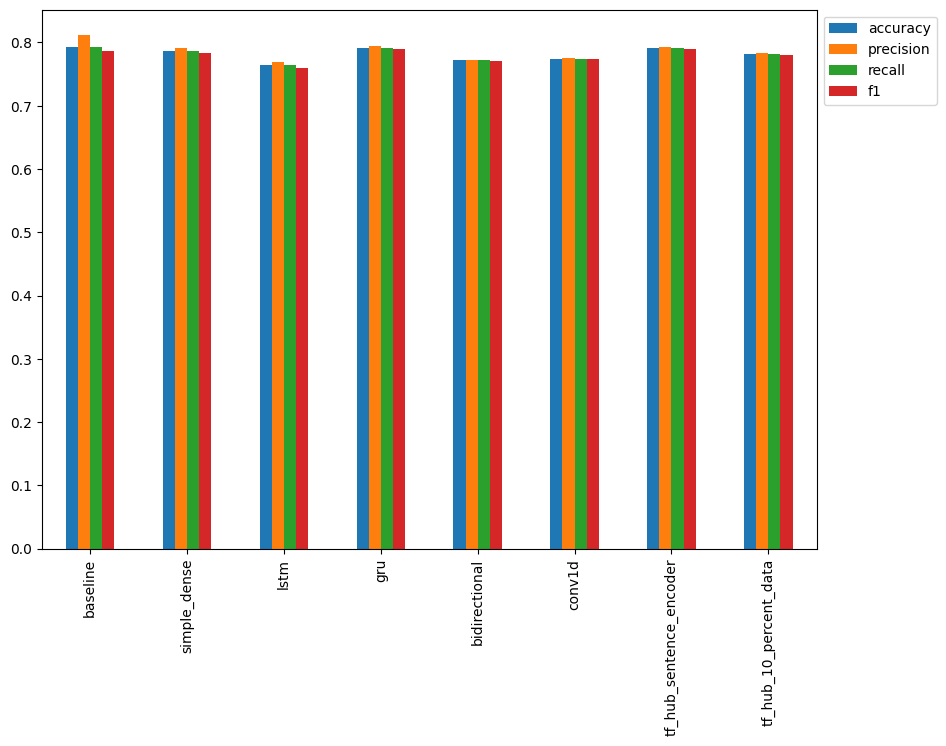

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

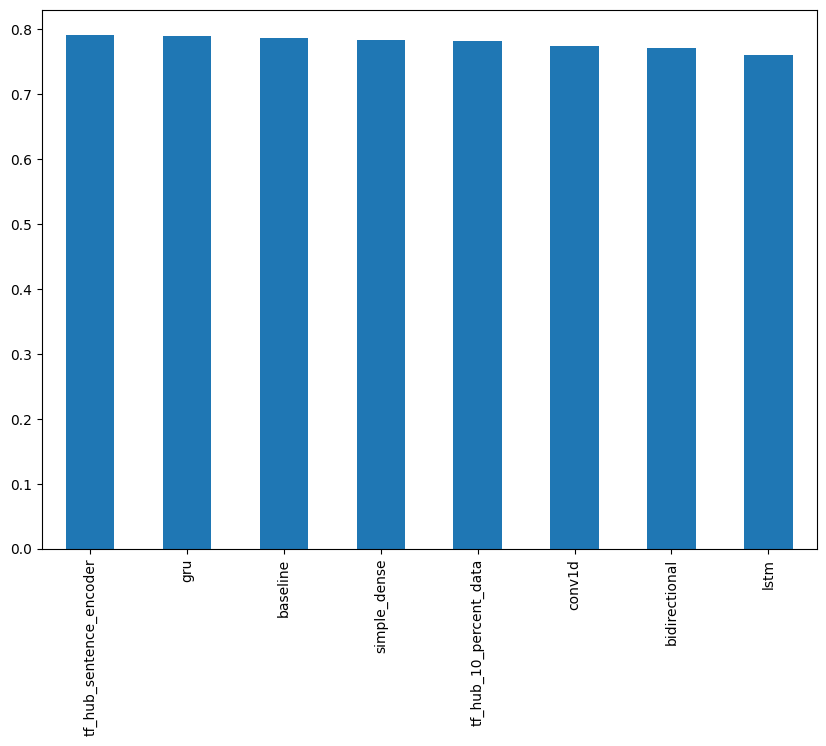

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));